## Package imports

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from skimage.filters import threshold_local

## ID selection

In [8]:
id = '91903177'

##### 

## RF bounding box detection

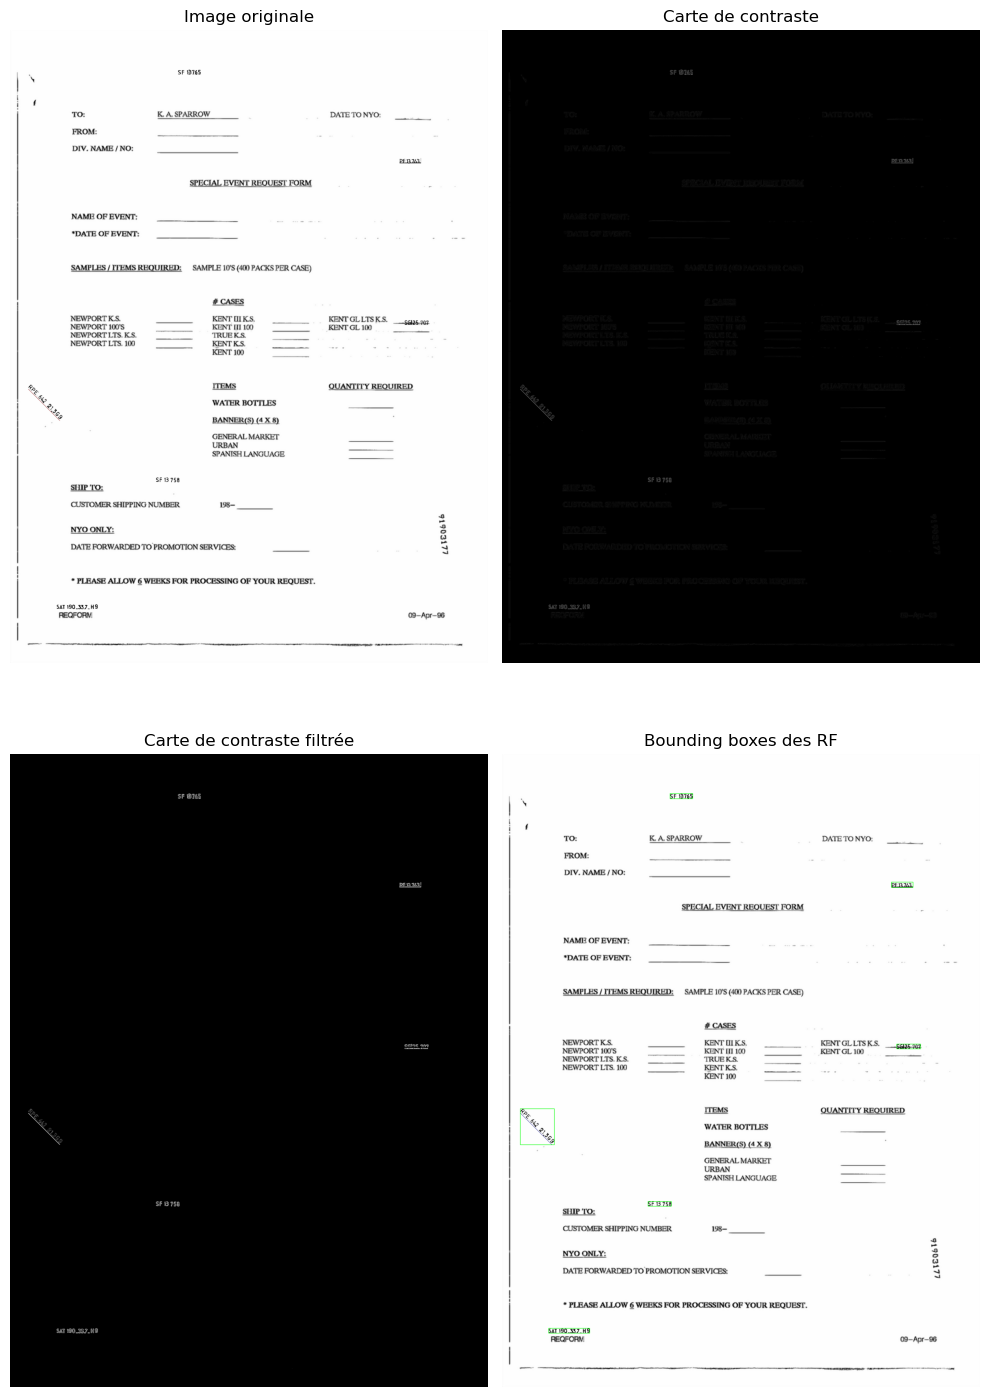

In [9]:
def get_RF_bboxes(id):
    image_path = f'data/test/images/{id}.png'
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # --- PARTIE 1: DÉTECTION DES ZONES ULTRA-CONTRASTÉES ---

    window_size = 5
    local_thresh = threshold_local(gray, window_size, offset=0, method='gaussian')
    contrast = np.abs(gray.astype(np.float32) - local_thresh)

    # --- PARTIE 2: FILTRAGE DES ZONES À CONTRASTE ÉLEVÉ ---

    thresh_value = 40
    contrast_thresh = np.zeros_like(contrast, dtype=np.uint8)
    contrast_thresh[contrast > thresh_value] = 255

    # --- PARTIE 3: DESSIN DES BOUNDING BOXES ---

    points = np.column_stack(np.where(contrast_thresh > 0))
    db = DBSCAN(eps=60, min_samples=50).fit(points)  #50,20
    labels = db.labels_
    unique_labels = set(labels)
    unique_labels.discard(-1)
    image_with_boxes = image.copy()
    for label in unique_labels:
        cluster_points = points[labels == label]
        x_min = np.min(cluster_points[:, 1])
        y_min = np.min(cluster_points[:, 0])
        x_max = np.max(cluster_points[:, 1])
        y_max = np.max(cluster_points[:, 0])
        cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    return image, contrast, contrast_thresh, image_with_boxes


image, contrast, contrast_thresh, image_with_boxes = get_RF_bboxes(id)

fig, axs = plt.subplots(2, 2, figsize=(10, 15))
axs[0,0].imshow(image)
axs[0,0].set_title('Image originale')
axs[0,0].axis('off')
axs[0,1].imshow(contrast, cmap='gray')
axs[0,1].set_title('Carte de contraste')
axs[0,1].axis('off')
axs[1,0].imshow(contrast_thresh, cmap='gray')
axs[1,0].set_title('Carte de contraste filtrée')
axs[1,0].axis('off')
axs[1,1].imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
axs[1,1].set_title('Bounding boxes des RF')
axs[1,1].axis('off')
plt.tight_layout()
plt.show()